# Object classification from synthetic data

In [239]:
# Import the numpy library for matrix manipulations etc.
import numpy as np
import pandas as pd
import os
import sys
import cv2 as cv2

# Set up the graphics by importing the matplotlib plotting library
import matplotlib.pyplot as plt

import keras as kr
from keras.models import Sequential
from keras.layers import Dense

shape_idx_to_name = {0:'disk', 1:'square', 2:'circle', 3:'triangle'}

In [258]:
def display_image(image_array, clim=None):
    """ Show a single image with colorbar. Image given in 1D or 2D representation. """
    
    if len(image_array.shape) == 1:
        image_dim = int(np.sqrt(len(image_array)))
        img = np.reshape(image_array, [image_dim, image_dim])
    else:
        img = image_array
        
    plt.imshow(img, interpolation='nearest', cmap='binary')
    if clim is None:
        plt.clim([img.min(),img.max()])
    else:
        plt.clim(clim)
        
    plt.colorbar()
    plt.show()

    
def create_training_data(data_sets, labels = [], p_train = 0.8):
    """ Create training and testing datasets from a collection of data sets.
    
        Function shuffles the given data_sets.
    
        Parameters:
        -----------
        data_sets : list of numpy.ndarray
            List of data sets, where every set is assumed to have the same label.
        labels : numpy.array
            Labels for each data set. If not given, assume labels = range(len(data_sets))
        p_train : 0.8, float
            Fraction of data used for training. Rest is used for testing.
        
        
        Returns:
        --------
        (trainX, trainY), (testX, testY)
    """

    data_sets_len = []
    for data in data_sets:
        data_sets_len.append(len(data))

    if len(labels) != len(data_sets):
        labels = np.array(list(range(len(data_sets))))
        
    N_data_total  = sum(data_sets_len)
    N_data_train = int(p_train * N_data_total)
    N_data_test  = int((1 - p_train) * N_data_total)
               
    totalX = np.concatenate(data_sets, axis=0)
    totalY = [np.array([label]*size) for label, size in zip(labels, data_sets_len)]
    
    totalY = np.concatenate(totalY, axis=0)

    # Shuffle data.
    totalX_randidx = np.array(range(N_data_total))
    np.random.shuffle(totalX_randidx)

    totalX = totalX[totalX_randidx]
    totalY = totalY[totalX_randidx]

    # Split into trian and test sets.
    trainX = totalX[:N_data_train]
    testX  = totalX[N_data_train:]

    trainY = totalY[:N_data_train]
    testY  = totalY[N_data_train:]
    
    return (trainX, trainY), (testX, testY)


class NN_Synth_obj_classifier:
    "Aboutaleb class for loading and training a neural net with synthetic generated data sets."

    def __init__(self, trainX, trainY, testX, testY, layers, activationFunc='sigmoid', lossFunc = 'categorical_crossentropy', optimizer = 'adam'):

        # Set images properties.
        self.trainX = self.load_images(trainX)
        self.testX  = self.load_images(testX)
        self.trainY = self.to_one_hot_encoding(trainY)
        self.testY  = self.to_one_hot_encoding(testY)
        
        self.image_size  = self.trainX.shape[-1] 
        self.trainX_size = len(self.trainX)
        
        # Set network properties.
        self.layers         = layers
        self.activationFunc = activationFunc
        self.lossFunc       = lossFunc
        self.optimizer      = optimizer
        
        # Build and train network.
        self.build_network()
        self.compile_network()
        
        # Nice names for numeric labels. (Set manually)
        self.shape_idx_to_name = dict(zip(np.unique(trainY), np.unique(trainY)))
        
    def load_images(self, images):
        
        if len(images.shape) < 3:
            return images
        
        image_dim = images.shape[-1]
        
        return images.reshape(-1, image_dim*image_dim)

    # Convert lablels to one-hot encoding.
    def to_one_hot_encoding(self, labels):   
        
        if len(labels.shape) == 2:
            return labels
        
        N_labels = len(np.unique(labels))

        train_Y_onehot = np.array([[0]*N_labels]*len(labels))
        for idx in range(len(train_Y_onehot)):
            train_Y_onehot[idx][labels[idx]] = 1
            
        return train_Y_onehot
        
    def build_network(self):
        net=kr.models.Sequential()
        net.add(kr.layers.Dense(self.layers[1], input_shape=(self.image_size,), activation=self.activationFunc))
        if(len(self.layers)>3):
            for li in self.layers[2:-1]:
                net.add(kr.layers.Dense(li, activation=self.activationFunc))
        net.add(kr.layers.Dense(self.layers[-1], activation='softmax'))
        self.net = net
            
    def compile_network(self):
        self.net.compile(loss=self.lossFunc,
                         optimizer=self.optimizer,
                         metrics=['categorical_accuracy'])
            
    def train_network(self, batch_size=100, epochs=30):
        self.history = self.net.fit(self.trainX, self.trainY, batch_size=batch_size, epochs=epochs)
        
    def test_network(self):
        testX_noise_props   = self.net.predict_on_batch(self.testX)
        testX_noise_results = np.argmax(testX_noise_props, axis=1)
        accuracy            = sum((np.argmax(self.testY, axis=1) - testX_noise_results) == 0)/len(self.testY) 
        
        return accuracy
    
    def test_example(self):
        
        rand_idx     = np.random.randint(len(self.testX))
        image_sample = self.testX[rand_idx]
        predict_prop = self.net.predict_on_batch(np.array([image_sample]))[0]
        predict_label = np.argmax(predict_prop)
        
        print('Label:', self.shape_idx_to_name[np.argmax(self.testY[rand_idx])], ', Prediction:', self.shape_idx_to_name[predict_label],\
              ', (prob=', predict_prop[predict_label] , ')')

        display_image(image_sample)

## Test OpenCV2 image library

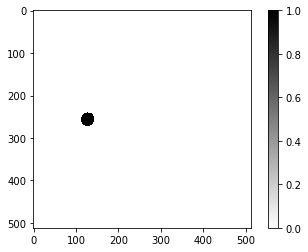

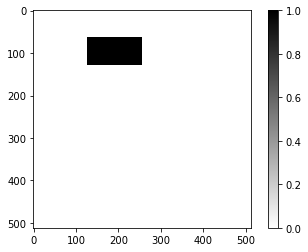

In [87]:
img1, img2 = np.zeros((2, 512, 512), np.uint8)

circle = cv2.circle(img1, (128, 256), 16, 1, -1)
square = cv2.rectangle(img2, (256, 128), (128,64), 1, -1)

display_image(circle)
display_image(square)

## Create synthetic trianing data

In [88]:
image_dim = 64
N_images  = 50000

r_max, r_min = int(image_dim/8), int(image_dim/2)
s_max, s_min = int(image_dim/8), int(image_dim/2)

image_size = image_dim*image_dim

#### Create random disks

In [147]:
circles_center_xy = np.random.randint(0, image_dim, (N_images, 2))
circles_radius    = np.random.randint(r_max, r_min, N_images)

images_disk = [cv2.circle(np.zeros((image_dim, image_dim), np.uint8), tuple(center_xy), r, 1, -1) for center_xy, r in zip(circles_center_xy, circles_radius)]
images_disk = np.array(images_disk)

#### Create random squares

In [148]:
squares_size = np.random.randint(s_max, s_min, N_images)

squares_topleft_xy     = np.random.randint(0, image_dim, (N_images, 2))
squares_bottomright_xy = squares_topleft_xy + np.array([squares_size, squares_size]).reshape(-1,2)

images_square = [cv2.rectangle(np.zeros((image_dim, image_dim), np.uint8), tuple(topleft_xy), tuple(bottomright_xy), 1, -1) for topleft_xy, bottomright_xy in zip(squares_topleft_xy, squares_bottomright_xy)]
images_square = np.array(images_square)

#### Create random circles

In [149]:
circles_center_xy = np.random.randint(0, image_dim, (N_images, 2))
circles_radius    = np.random.randint(r_max, r_min, N_images)

images_cicle = [cv2.circle(np.zeros((image_dim, image_dim), np.uint8), tuple(center_xy), r, 1, 4) for center_xy, r in zip(circles_center_xy, circles_radius)]
images_cicle = np.array(images_cicle)

#### Create random triangles.

In [234]:
base_triangle_vertices = np.array([[0,0], [10,0], [5, 6]], np.int32) #np.int32

pos_min, pos_max = 0, int(0.5*image_dim)
dE = int(0.5*image_dim)

triangles_bottom_left = np.random.randint(pos_min, pos_max, (N_images, 2))
triangles_E12         = np.random.randint(10, dE, (N_images, 2))
triangles_E13         = np.random.randint(10, dE, (N_images, 2))

triangles_vertex_1 = triangles_bottom_left
triangles_vertex_2 = triangles_bottom_left + triangles_E12
triangles_vertex_3 = triangles_bottom_left + triangles_E13

triangles_vertex_123 = np.array([[v1, v2, v3] for v1, v2, v3 in zip(triangles_vertex_1, triangles_vertex_2, triangles_vertex_3)], np.int32)
triangles_vertex_123 = triangles_vertex_123.reshape((-1,1,3,2))
#image_test = cv2.polylines(np.zeros((512, 512), np.uint8),[pts],True,1)

images_triangle = [cv2.polylines(np.zeros((image_dim, image_dim), np.int32), tuple(vertex_123), True, 1, 2) for vertex_123 in triangles_vertex_123]
images_triangle = np.array(images_triangle)

In [211]:
triangles_vertex_123 = np.array([[v1, v2, v3] for v1, v2, v3 in zip(triangles_vertex_1, triangles_vertex_2, triangles_vertex_3)], np.int32)

In [220]:
pts = triangles_vertex_123[:2]
pts = pts.reshape((-1,1,3,2))
a = cv2.polylines(np.zeros((image_dim, image_dim), np.int32), [pts[1]] ,True,1,2)

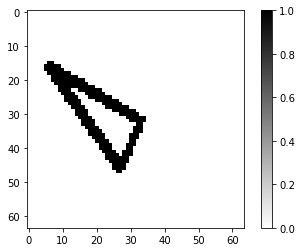

In [236]:
display_image(images_triangle[0])

#### Create train and test datasets

In [237]:
(trainX, trainY), (testX, testY) = create_training_data([images_disk, images_square, images_cicle, images_triangle])

In [ ]:
for idx in range(10):
    rand_idx = np.random.randint(len(trainX))
    print(rand_idx, shape_idx_to_name[trainY[rand_idx]])
    display_image(trainX[rand_idx])

### Train clasifier NN on fixed sized shapes

In [281]:
NN_circle_square = NN_Synth_obj_classifier(trainX, trainY, testX, testY, layers = [image_size, 32, 4])
NN_circle_square.shape_idx_to_name = shape_idx_to_name

In [285]:
NN_circle_square.train_network(epochs=1)

Epoch 1/1
160000/160000 [==============================] - 13s 84us/step - loss: 0.1381 - categorical_accuracy: 0.9550


In [286]:
NN_circle_square.test_network()

0.950925

Label: circle , Prediction: circle , (prob= 0.9666539 )


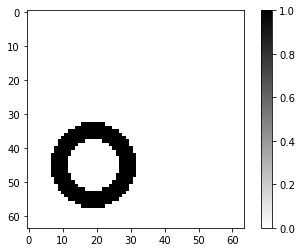

In [287]:
NN_circle_square.test_example()

### Visualize weights

In [ ]:
for layer in model.layers:
    weights = layer.get_weights() # list of numpy arrays

In [289]:
weight_matrices = []
for layer in NN_circle_square.net.layers:
    weight_matrices.append(layer.get_weights())

In [290]:
weight_matrices[0][0].shape

(4096, 32)